In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import collections
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../')
from utils import load_results
from utils import precision_recall_scores as roc
from utils import mpl_stylesheet
from utils import utils
# mpl_stylesheet.banskt_presentation(fontfamily = 'system', colors = "kelly")
from functools import wraps
import time

def timeit(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time.time()
        result = f(*args, **kw)
        te = time.time()
        print('{:s} took: {:.6f} seconds'.format(f.__name__, te-ts))
        return result
    return wrap

import mpmath

mpmath.mp.dps = 500
def pval(x): return float(mpmath.log10(1 - 0.5 * (1 + mpmath.erf(x/mpmath.sqrt(2)))))

def load_tejaas_qscaled(filepath):
    res = dict()
    with open(filepath, 'r') as mfile:
        next(mfile)
        for line in mfile:
            arr   = line.strip().split("\t")
            rsid  = arr[0]
            p     = float(arr[5])
            q     = float(arr[2])
            mu    = float(arr[3])
            sigma = float(arr[4])
            if sigma == 0:
                continue
            res[rsid] = (q-mu)/sigma         
    return res

def load_tejaas_pvals(filepath):
    res = dict()
    with open(filepath, 'r') as mfile:
        next(mfile)
        for line in mfile:
            arr   = line.strip().split("\t")
            rsid  = arr[0]
            p     = float(arr[5])
            q     = float(arr[2])
            mu    = float(arr[3])
            sigma = float(arr[4])
            if sigma == 0:
                continue
            myp  = p if p != 0 else pval( (q - mu) / sigma)
            res[rsid] = p
            if np.isinf(p) or np.isnan(p):
                print(filepath)
                print(rsid, p)
    return res

def get_dict_for_method(method, input_dir, chrms, tissue, sb = '0.01', datatype = 'qscaled'):
    chrmdicts = [dict() for c in chrms]
    datadir = os.path.join(input_dir, tissue)
    print("Reading {:s} for {:s}".format(tissue, method))
    for i, chrm in enumerate(chrms):
        if method.startswith('tejaas'):
            filepath = os.path.join(datadir, method, 'permnull_sb{:s}'.format(sb), 'chr{:d}'.format(chrm), 'rr.txt')
            print("Loading ", filepath)
            if os.path.exists(filepath):
                if datatype == "qscaled":
                    chrmdicts[i] = load_tejaas_qscaled(filepath)
                elif datatype == "pvals":
                    chrmdicts[i] = load_tejaas_pvals(filepath)
            else:
                raise
    res = dict()
    for d in chrmdicts:
        for k, v in d.items():
            res[k] = v
    return res

INFO_FIELDS = ['rsid', 'stat', 'causality']
class ValidateResult(collections.namedtuple('_ValidateResult', INFO_FIELDS)):
    __slots__ = ()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from statsmodels.stats import multitest
reject, bhlist, _a, _b = multitest.multipletests(pvallist, method="fdr_bh")


In [2]:
import itertools 
# aa 197
# nt 256
# fib 272
# sse 302
# ms 361
chrms = [6, 7, 8]
datasets = ['gtex-ms', 'gtex-sse'] #, 'gtex-fib', 'gtex-nt', 'gtex-aa']
sizes = [361, 302] #, 272, 256, 197]
size_dict = dict(zip(datasets, sizes))
methods = [ 'tejaas']
sbs = ["0.01", "0.02", "0.03", "0.04", "0.05", "0.06"]
expressions = ["peer10"]
expr = expressions[0]
input_dir = '/cbscratch/franco/trans-eqtl/dev-pipeline/sb_scan/'+expr

In [4]:
# Load all Qscaled or pval data
def load_data(input_dir, methods, chrms, datasets, sbs, datatype = "qscaled"):
    allmethods = list()
    data = collections.defaultdict(dict)
    for dataset in datasets:
        data[dataset] = collections.defaultdict(dict)
        for key in methods:
            if key.startswith("tejaas"):
                for sb in sbs:
                    mkey = key + "_" + sb
                    print("Loading",mkey)
                    data[dataset][mkey] = get_dict_for_method(key, input_dir, chrms, dataset, sb, datatype=datatype)
                    if mkey not in allmethods: allmethods.append(mkey) 
            else:
                raise
    return data

# qdata = load_data(input_dir, methods, chrms, datasets, sbs, datatype = "qscaled")

In [ ]:
# For plotting all six datasets pvals (as histogram)

fig = plt.figure(figsize=(14,21))
axis = 1
outfile = "../plots/sigma_beta_scan.png"
for key in methods:
    if key.startswith("tejaas"):
        for dataset in datasets:
            ax  = fig.add_subplot(320+ axis)
            pvallist = list()
            labels = list()
            
            for sb in sbs:
                mkey = key + "_" + sb
                pvals = np.array(list(pdata[dataset][mkey].values()))
                col = np.floor(axis / 2) + 1
                row = np.floor(axis / 3) + 1
                pvallist.append(pvals)
                labels.append(dataset+ "-" +mkey + " - "+str(size_dict[dataset])+ " samples")
            ax.hist(pvallist, bins=15, label=labels)
            ax.legend()
            axis += 1
# plt.savefig(outfile, bbox_inches='tight')
plt.show()
                    

In [ ]:
# For plotting all six datasets pvals (as density)
from scipy.stats import gaussian_kde

fig = plt.figure(figsize=(16,22))
axis = 1
outfile = "../plots/sigma_beta_scan_Qscaled.png"
for key in methods:
    if key.startswith("tejaas"):
        for dataset in datasets:
            ax  = fig.add_subplot(320+ axis)
            Qlist = list()
            labels = list()
            
#             for sb in sbs:
#                 mkey = key + "_" + sb
#                 print(mkey)
#                 qscaled = np.array(list(qdata[dataset][mkey].values()))
#                 print(qscaled)
#                 col = np.floor(axis / 2) + 1
#                 row = np.floor(axis / 3) + 1
#                 Qlist.append(qscaled)
#                 Qlist = qscaled
#                 labels.append(dataset+ "-" +mkey + " - "+str(size_dict[dataset])+ " samples")
                
            for sb in sbs:
                mkey = key + "_" + sb
                qscaled = np.array(list(qdata[dataset][mkey].values()))
                col = np.floor(axis / 2) + 1
                row = np.floor(axis / 3) + 1
                density = gaussian_kde(qscaled)
                xs = np.linspace(-10,6,200)
                density.covariance_factor = lambda : .25
                density._compute_covariance()
                label = dataset+ "-" +mkey + " - "+str(size_dict[dataset])+ "nS"
                ax.plot(xs,density(xs), label=label)
                
            N01 = np.random.normal(size=len(qscaled))
            density = gaussian_kde(N01)
            density.covariance_factor = lambda : .25
            density._compute_covariance()
            ax.plot(xs,density(xs), label="N(0,1)")
            
#             ax.hist(Qlist, bins=15, label=labels)
            ax.legend(loc='upper left')
            axis += 1
plt.savefig(outfile, bbox_inches='tight')
plt.show()

In [17]:
chrms = [6, 7, 8]
datasets = ['gtex-ms'] #, 'gtex-sse'] 
sizes = [361, 302]
size_dict = dict(zip(datasets, sizes))
methods = ['tejaas_rand']
sbs = ["0.01", "0.02", "0.03", "0.04", "0.05", "0.06"]
expressions = ["lmcorrected_age"]
expr = expressions[0]
input_dir = '/cbscratch/franco/trans-eqtl/dev-pipeline/sb_scan_new/'+expr

qdata = load_data(input_dir, methods, chrms, datasets, sbs, datatype = "qscaled")

Loading tejaas_rand_0.01
Reading gtex-ms for tejaas_rand
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/sb_scan_new/lmcorrected_age/gtex-ms/tejaas_rand/permnull_sb0.01/chr6/rr.txt
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/sb_scan_new/lmcorrected_age/gtex-ms/tejaas_rand/permnull_sb0.01/chr7/rr.txt
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/sb_scan_new/lmcorrected_age/gtex-ms/tejaas_rand/permnull_sb0.01/chr8/rr.txt
Loading tejaas_rand_0.02
Reading gtex-ms for tejaas_rand
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/sb_scan_new/lmcorrected_age/gtex-ms/tejaas_rand/permnull_sb0.02/chr6/rr.txt
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/sb_scan_new/lmcorrected_age/gtex-ms/tejaas_rand/permnull_sb0.02/chr7/rr.txt
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/sb_scan_new/lmcorrected_age/gtex-ms/tejaas_rand/permnull_sb0.02/chr8/rr.txt
Loading tejaas_rand_0.03
Reading gtex-ms for tejaas_rand
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/sb_scan_new/lmco

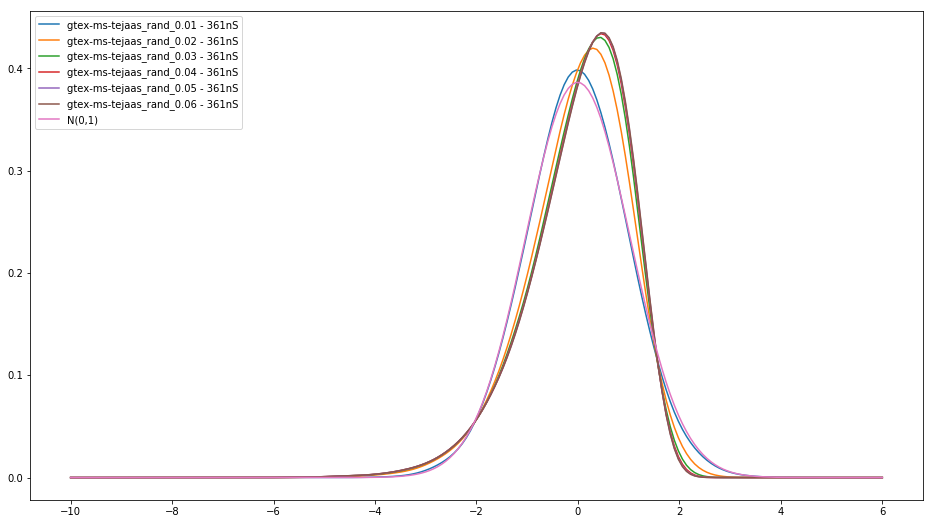

In [18]:
# For plotting all six datasets pvals (as density)
from scipy.stats import gaussian_kde

fig = plt.figure(figsize=(16,9))
axis = 1
outfile = "../plots/sigma_beta_scan_Qscaled_"+expr+"_"+methods[0]+".png"
for key in methods:
    if key.startswith("tejaas"):
        for dataset in datasets:
            ax  = fig.add_subplot(110+ axis)
            Qlist = list()
            labels = list()
            for sb in sbs:
                mkey = key + "_" + sb
                qscaled = np.array(list(qdata[dataset][mkey].values()))
                density = gaussian_kde(qscaled)
                xs = np.linspace(-10,6,200)
                density.covariance_factor = lambda : .25
                density._compute_covariance()
                label = dataset+ "-" +mkey + " - "+str(size_dict[dataset])+ "nS"
                ax.plot(xs,density(xs), label=label)
                
            N01 = np.random.normal(size=len(qscaled))
            density = gaussian_kde(N01)
            density.covariance_factor = lambda : .25
            density._compute_covariance()
            ax.plot(xs,density(xs), label="N(0,1)")
            
            ax.legend(loc='upper left')
            axis += 1
plt.savefig(outfile, bbox_inches='tight')
plt.show()

In [19]:
chrms = [6, 7, 8]
datasets = ['gtex-ms'] 
sizes = [361]
size_dict = dict(zip(datasets, sizes))
methods = ['tejaas_rand']
sbs = ["0.01", "0.02", "0.03", "0.04", "0.05", "0.06"]
expressions = ["lmcorrected_age"]
expr = expressions[0]
input_dir = '/cbscratch/franco/trans-eqtl/dev-pipeline/sb_scan_new_quant_norm/'+expr

qdata = load_data(input_dir, methods, chrms, datasets, sbs, datatype = "qscaled")

Loading tejaas_rand_0.01
Reading gtex-ms for tejaas_rand
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/sb_scan_new_quant_norm/lmcorrected_age/gtex-ms/tejaas_rand/permnull_sb0.01/chr6/rr.txt
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/sb_scan_new_quant_norm/lmcorrected_age/gtex-ms/tejaas_rand/permnull_sb0.01/chr7/rr.txt
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/sb_scan_new_quant_norm/lmcorrected_age/gtex-ms/tejaas_rand/permnull_sb0.01/chr8/rr.txt
Loading tejaas_rand_0.02
Reading gtex-ms for tejaas_rand
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/sb_scan_new_quant_norm/lmcorrected_age/gtex-ms/tejaas_rand/permnull_sb0.02/chr6/rr.txt
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/sb_scan_new_quant_norm/lmcorrected_age/gtex-ms/tejaas_rand/permnull_sb0.02/chr7/rr.txt
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/sb_scan_new_quant_norm/lmcorrected_age/gtex-ms/tejaas_rand/permnull_sb0.02/chr8/rr.txt
Loading tejaas_rand_0.03
Reading gtex-ms for tejaas_rand
L

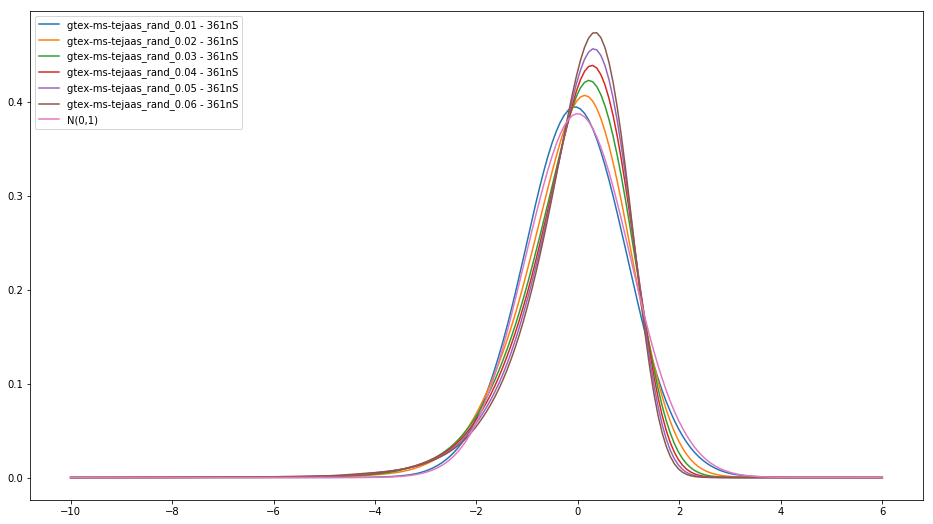

In [20]:

fig = plt.figure(figsize=(16,9))
axis = 1
outfile = "../plots/sigma_beta_scan_QUANT_NORM_Qscaled_"+expr+"_"+methods[0]+".png"
for key in methods:
    if key.startswith("tejaas"):
        for dataset in datasets:
            ax  = fig.add_subplot(110+ axis)
            Qlist = list()
            labels = list()
            
            for sb in sbs:
                mkey = key + "_" + sb
                qscaled = np.array(list(qdata[dataset][mkey].values()))
                density = gaussian_kde(qscaled)
                xs = np.linspace(-10,6,200)
                density.covariance_factor = lambda : .25
                density._compute_covariance()
                label = dataset+ "-" +mkey + " - "+str(size_dict[dataset])+ "nS"
                ax.plot(xs,density(xs), label=label)
                
            N01 = np.random.normal(size=len(qscaled))
            density = gaussian_kde(N01)
            density.covariance_factor = lambda : .25
            density._compute_covariance()
            ax.plot(xs,density(xs), label="N(0,1)")
            
            ax.legend(loc='upper left')
            axis += 1
plt.savefig(outfile, bbox_inches='tight')
plt.show()

In [26]:
chrms = [6] #, 7, 8]
datasets = ['gtex-ms'] 
sizes = [361]
size_dict = dict(zip(datasets, sizes))
methods = ['tejaas_rand']
sbs = ["0.01", "0.02", "0.03", "0.04", "0.05", "0.06"]
expressions = ["lmcorrected_age"]
expr = expressions[0]
input_dir = '/cbscratch/franco/trans-eqtl/dev-pipeline/sb_scan_new_MYQUANT_norm/'+expr

qdata = load_data(input_dir, methods, chrms, datasets, sbs, datatype = "qscaled")

Loading tejaas_rand_0.01
Reading gtex-ms for tejaas_rand
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/sb_scan_new_MYQUANT_norm/lmcorrected_age/gtex-ms/tejaas_rand/permnull_sb0.01/chr6/rr.txt
Loading tejaas_rand_0.02
Reading gtex-ms for tejaas_rand
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/sb_scan_new_MYQUANT_norm/lmcorrected_age/gtex-ms/tejaas_rand/permnull_sb0.02/chr6/rr.txt
Loading tejaas_rand_0.03
Reading gtex-ms for tejaas_rand
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/sb_scan_new_MYQUANT_norm/lmcorrected_age/gtex-ms/tejaas_rand/permnull_sb0.03/chr6/rr.txt
Loading tejaas_rand_0.04
Reading gtex-ms for tejaas_rand
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/sb_scan_new_MYQUANT_norm/lmcorrected_age/gtex-ms/tejaas_rand/permnull_sb0.04/chr6/rr.txt
Loading tejaas_rand_0.05
Reading gtex-ms for tejaas_rand
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/sb_scan_new_MYQUANT_norm/lmcorrected_age/gtex-ms/tejaas_rand/permnull_sb0.05/chr6/rr.txt
Loading tejaas_

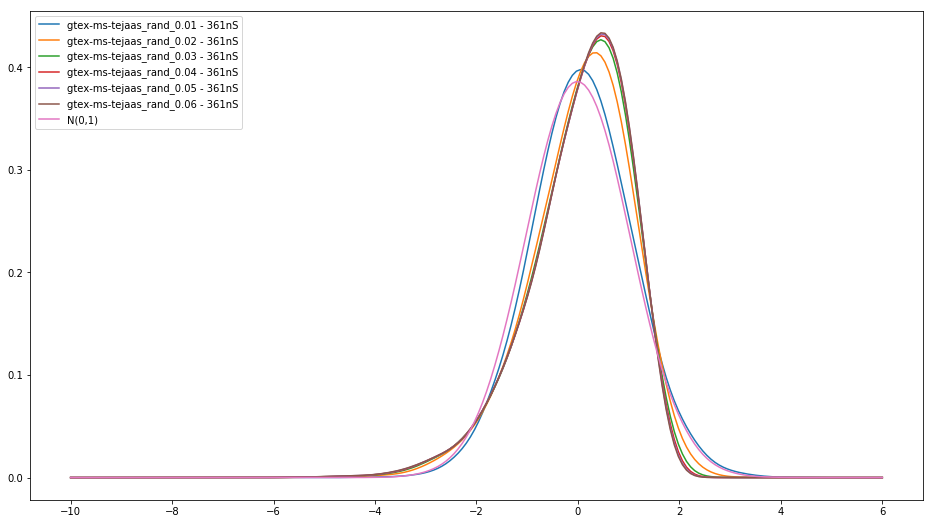

In [27]:
from scipy.stats import gaussian_kde

fig = plt.figure(figsize=(16,9))
axis = 1
outfile = "../plots/sigma_beta_scan_MY_QUANT_NORM_Qscaled_"+expr+"_"+methods[0]+".png"
for key in methods:
    if key.startswith("tejaas"):
        for dataset in datasets:
            ax  = fig.add_subplot(110+ axis)
            Qlist = list()
            labels = list()
            
            for sb in sbs:
                mkey = key + "_" + sb
                qscaled = np.array(list(qdata[dataset][mkey].values()))
                density = gaussian_kde(qscaled)
                xs = np.linspace(-10,6,200)
                density.covariance_factor = lambda : .25
                density._compute_covariance()
                label = dataset+ "-" +mkey + " - "+str(size_dict[dataset])+ "nS"
                ax.plot(xs,density(xs), label=label)
                
            N01 = np.random.normal(size=len(qscaled))
            density = gaussian_kde(N01)
            density.covariance_factor = lambda : .25
            density._compute_covariance()
            ax.plot(xs,density(xs), label="N(0,1)")
            
            ax.legend(loc='upper left')
            axis += 1
plt.savefig(outfile, bbox_inches='tight')
plt.show()

In [21]:
pdata = load_data(input_dir, methods, chrms, datasets, sbs, datatype = "pvals")

Loading tejaas_rand_0.01
Reading gtex-ms for tejaas_rand
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/sb_scan_new_MYQUANT_norm/lmcorrected_age/gtex-ms/tejaas_rand/permnull_sb0.01/chr6/rr.txt
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/sb_scan_new_MYQUANT_norm/lmcorrected_age/gtex-ms/tejaas_rand/permnull_sb0.01/chr7/rr.txt
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/sb_scan_new_MYQUANT_norm/lmcorrected_age/gtex-ms/tejaas_rand/permnull_sb0.01/chr8/rr.txt
Loading tejaas_rand_0.02
Reading gtex-ms for tejaas_rand
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/sb_scan_new_MYQUANT_norm/lmcorrected_age/gtex-ms/tejaas_rand/permnull_sb0.02/chr6/rr.txt
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/sb_scan_new_MYQUANT_norm/lmcorrected_age/gtex-ms/tejaas_rand/permnull_sb0.02/chr7/rr.txt
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/sb_scan_new_MYQUANT_norm/lmcorrected_age/gtex-ms/tejaas_rand/permnull_sb0.02/chr8/rr.txt
Loading tejaas_rand_0.03
Reading gtex-ms for t

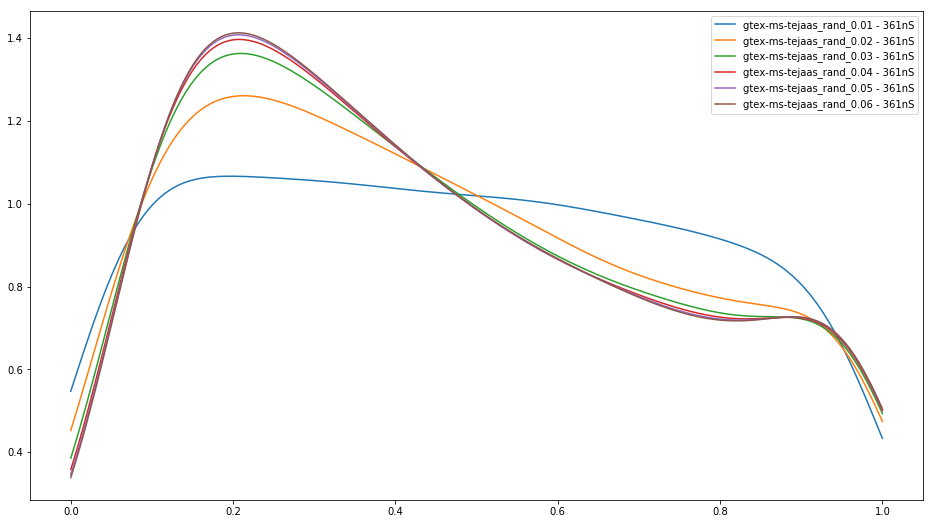

In [25]:
fig = plt.figure(figsize=(16,9))
axis = 1
for key in methods:
    if key.startswith("tejaas"):
        for dataset in datasets:
            ax  = fig.add_subplot(110+ axis)
            for sb in sbs:
                mkey = key + "_" + sb
                pvals = np.array(list(pdata[dataset][mkey].values()))
                label = dataset+ "-" +mkey + " - "+str(size_dict[dataset])+ "nS"
                density = gaussian_kde(pvals)
                xs = np.linspace(0,1,200)
                density.covariance_factor = lambda : .25
                density._compute_covariance()
                label = dataset+ "-" +mkey + " - "+str(size_dict[dataset])+ "nS"
                ax.plot(xs,density(xs), label=label)
#                 ax.hist(pvals, bins=50, label=label)
            ax.legend()
            axis += 1
plt.show()

In [34]:
chrms = [6, 7, 8]
datasets = ['gtex-ms'] 
sizes = [361]
size_dict = dict(zip(datasets, sizes))
methods = ['tejaas_rand']
sbs = ["0.01", "0.02", "0.03", "0.04", "0.05", "0.06"]
expressions = ["lmcorrected_age"]
expr = expressions[0]
input_dir = '/cbscratch/franco/trans-eqtl/dev-pipeline/sb_scan_new_precovar_norm/'+expr

qdata = load_data(input_dir, methods, chrms, datasets, sbs, datatype = "qscaled")

Loading tejaas_rand_0.01
Reading gtex-ms for tejaas_rand
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/sb_scan_new_precovar_norm/lmcorrected_age/gtex-ms/tejaas_rand/permnull_sb0.01/chr6/rr.txt
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/sb_scan_new_precovar_norm/lmcorrected_age/gtex-ms/tejaas_rand/permnull_sb0.01/chr7/rr.txt
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/sb_scan_new_precovar_norm/lmcorrected_age/gtex-ms/tejaas_rand/permnull_sb0.01/chr8/rr.txt
Loading tejaas_rand_0.02
Reading gtex-ms for tejaas_rand
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/sb_scan_new_precovar_norm/lmcorrected_age/gtex-ms/tejaas_rand/permnull_sb0.02/chr6/rr.txt
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/sb_scan_new_precovar_norm/lmcorrected_age/gtex-ms/tejaas_rand/permnull_sb0.02/chr7/rr.txt
Loading  /cbscratch/franco/trans-eqtl/dev-pipeline/sb_scan_new_precovar_norm/lmcorrected_age/gtex-ms/tejaas_rand/permnull_sb0.02/chr8/rr.txt
Loading tejaas_rand_0.03
Reading gtex-ms

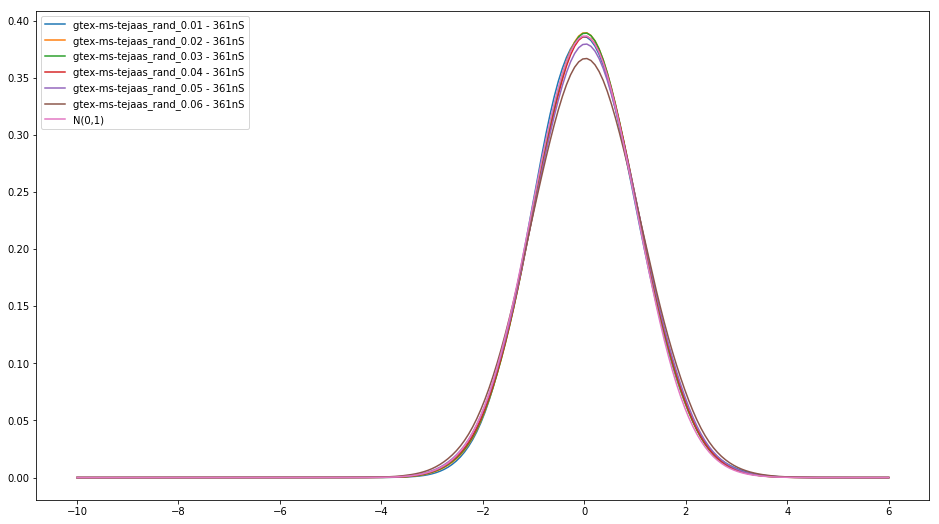

In [35]:
from scipy.stats import gaussian_kde

fig = plt.figure(figsize=(16,9))
axis = 1
outfile = "../plots/sigma_beta_scan_precovar_MY_QUANT_NORM_Qscaled_"+expr+"_"+methods[0]+".png"
for key in methods:
    if key.startswith("tejaas"):
        for dataset in datasets:
            ax  = fig.add_subplot(110+ axis)
            Qlist = list()
            labels = list()
            
            for sb in sbs:
                mkey = key + "_" + sb
                qscaled = np.array(list(qdata[dataset][mkey].values()))
                density = gaussian_kde(qscaled)
                xs = np.linspace(-10,6,200)
                density.covariance_factor = lambda : .25
                density._compute_covariance()
                label = dataset+ "-" +mkey + " - "+str(size_dict[dataset])+ "nS"
                ax.plot(xs,density(xs), label=label)
                
            N01 = np.random.normal(size=len(qscaled))
            density = gaussian_kde(N01)
            density.covariance_factor = lambda : .25
            density._compute_covariance()
            ax.plot(xs,density(xs), label="N(0,1)")
            
            ax.legend(loc='upper left')
            axis += 1
plt.savefig(outfile, bbox_inches='tight')
plt.show()